##### Find out if matrix D is following some random distribution or not

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:

import mubind as mb

Matplotlib is building the font cache; this may take a moment.


In [3]:
import torch
import numpy as np
import pandas as pd
import sys
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
import sys
sys.path.append('/Users/lennartredl/Desktop/MachineLearningProjects/TheisLab_Mubind/mubindNew')


In [5]:
cd ../../..


/Users/lennartredl/Documents/MachineLearningProjects/TheisLab_Mubind/mubindNew


In [6]:
import mubind as mb

In [7]:
# changing directory remove if another filesystem
mb.tl.graph

<module 'mubind.tl.graph' from '/Users/lennartredl/Documents/MachineLearningProjects/TheisLab_Mubind/mubindNew/mubind/tl/graph.py'>

In [8]:
cd docs/notebooks/single_cell

/Users/lennartredl/Documents/MachineLearningProjects/TheisLab_Mubind/mubindNew/docs/notebooks/single_cell


In [9]:
# load models
model_by_logdynamic = {}
for use_logdynamic in [False, True]:
    p = 'pancreas_multiome_use_logdynamic_%i.pth' % use_logdynamic
    # p = 'noack_2022_use_logdynamic_%i.pth' % use_logdynamic
    print(p)
    model_by_logdynamic[use_logdynamic] = torch.load(p)

pancreas_multiome_use_logdynamic_0.pth
pancreas_multiome_use_logdynamic_1.pth


In [10]:
model = model_by_logdynamic[1]

In [11]:
# for convenience
tsum = torch.sum
texp = torch.exp
tspa = torch.sparse_coo_tensor
tsmm = torch.sparse.mm
t = torch.transpose

# get the connectivity and weight matrix from the model
C = model.graph_module.conn_sparse
a_ind = C.indices()
D = model.graph_module.log_dynamic
D_tril = tspa(a_ind, D, C.shape) 
D_triu = tspa(a_ind, -D, C.shape)  
D = D_tril + torch.transpose(D_triu, 0, 1)

In [12]:
try:
    import mubind.tl.graph as graph
    print("graph module contents:", dir(graph))
except ModuleNotFoundError as e:
    print(f"Error importing graph module: {e}")

try:
    from mubind.tl.graph import metric_scramble_comparison
    print("metric_scramble_comparison function:", metric_scramble_comparison)
except ImportError as e:
    print(f"Error importing metric_scramble_comparison: {e}")


graph module contents: ['__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'compute_contributions', 'metric_scramble_comparison', 'normalized_alignment_score', 'np', 'pd', 'torch']
metric_scramble_comparison function: <function metric_scramble_comparison at 0x7f9ad2b033a0>


In [13]:
import mubind as mb

scramble = mb.tl.metric_scramble_comparison
normalized = mb.tl.normalized_alignment_score

scores_alignment_flat = scramble(C, D, normalized, 'flat', verbose=0)
scores_alignment_row = scramble(C, D, normalized, 'row', verbose=0)
scores_alignment_column = scramble(C, D, normalized, 'column', verbose=0)
original_score = normalized(C, D)


In [14]:
def hist(x, y, lab1, lab2, title,
         xlab='Normalized Alignment Score',
         ylab='Frequency'):
    plt.hist(x, bins=30, alpha=0.7, label=lab1)
    plt.axvline(y,
                color='r',
                linestyle='dashed',
                linewidth=2,
                label=lab2)
    plt.title(title)
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.legend()


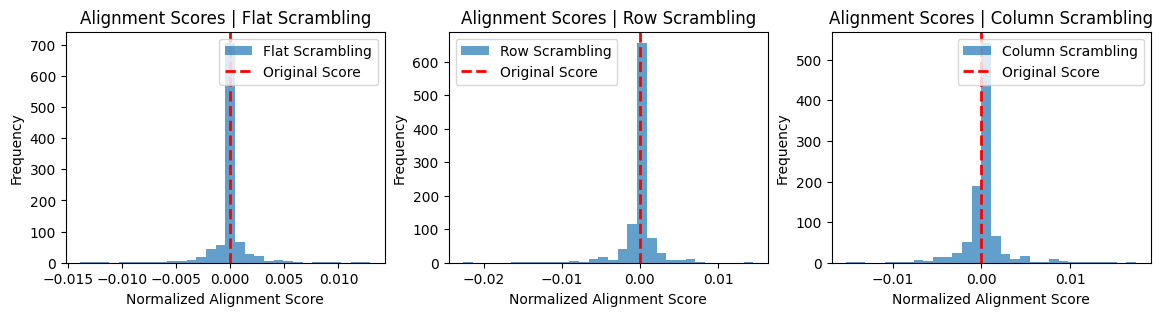

In [15]:
plt.figure(figsize=(14, 3))
# flat scrambling
plt.subplot(1, 3, 1)
hist(scores_alignment_flat,
     original_score,
     'Flat Scrambling',
     'Original Score',
     'Alignment Scores | Flat Scrambling')
# row scrambling
plt.subplot(1, 3, 2)
hist(scores_alignment_row,
     original_score,
     'Row Scrambling',
     'Original Score',
     'Alignment Scores | Row Scrambling')
# column scrambling
plt.subplot(1, 3, 3)
hist(scores_alignment_column,
     original_score,
     'Column Scrambling',
     'Original Score',
     'Alignment Scores | Column Scrambling')
plt.show()

In [16]:

positives_alignment_flat = scramble(C, C, normalized, 'flat', verbose=0)
positives_alignment_row = scramble(C, C, normalized, 'row', verbose=0)
positives_alignment_column = scramble(C, C, normalized, 'column', verbose=0)
positives_original_score = normalized(C, C)

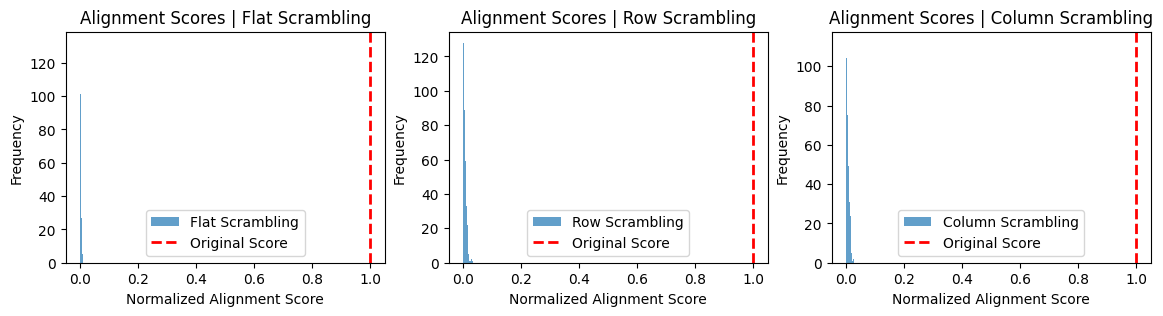

In [17]:
plt.figure(figsize=(14, 3))
plt.subplot(1, 3, 1)

hist(positives_alignment_flat,
     positives_original_score,
     'Flat Scrambling',
     'Original Score',
     'Alignment Scores | Flat Scrambling')

plt.subplot(1, 3, 2)
hist(positives_alignment_row,
     positives_original_score,
     'Row Scrambling',
     'Original Score',
     'Alignment Scores | Row Scrambling')

plt.subplot(1, 3, 3)
hist(positives_alignment_column,
     positives_original_score,
     'Column Scrambling',
     'Original Score',
     'Alignment Scores | Column Scrambling')


#### Understand the contribution of the filters

In [18]:
print(model.get_log_activities())

ParameterList(
    (0): Parameter containing: [torch.float32 of size 1x496]
    (1): Parameter containing: [torch.float32 of size 1x496]
    (2): Parameter containing: [torch.float32 of size 1x496]
    (3): Parameter containing: [torch.float32 of size 1x496]
    (4): Parameter containing: [torch.float32 of size 1x496]
    (5): Parameter containing: [torch.float32 of size 1x496]
    (6): Parameter containing: [torch.float32 of size 1x496]
    (7): Parameter containing: [torch.float32 of size 1x496]
    (8): Parameter containing: [torch.float32 of size 1x496]
    (9): Parameter containing: [torch.float32 of size 1x496]
    (10): Parameter containing: [torch.float32 of size 1x496]
    (11): Parameter containing: [torch.float32 of size 1x496]
    (12): Parameter containing: [torch.float32 of size 1x496]
    (13): Parameter containing: [torch.float32 of size 1x496]
    (14): Parameter containing: [torch.float32 of size 1x496]
    (15): Parameter containing: [torch.float32 of size 1x496]
   

In [19]:
# Y_com = B @ A @ (G * D)

In [20]:

# considering  graph-independent effects
# indices, contributions, max_eig = compute_contributions(B.T @ A.T, C * D)


In [21]:
A = torch.cat([activity.data for activity in model.get_log_activities()])
print(A)
print(A.shape)

tensor([[-2.0708e-06, -1.1779e-06, -1.7033e-06,  ..., -1.1779e-06,
         -2.4437e-06, -1.1779e-06],
        [-1.2006e-04, -6.6639e-05, -8.9532e-05,  ..., -6.6639e-05,
         -1.4285e-04, -6.6639e-05],
        [-8.6376e-04, -4.9427e-04, -4.6408e-04,  ..., -4.9427e-04,
         -1.1545e-03, -4.9427e-04],
        ...,
        [-7.1370e-02, -4.2256e-02, -5.4299e-02,  ..., -4.2256e-02,
         -7.5210e-02, -4.2256e-02],
        [-1.7568e-02, -9.6862e-03, -1.7253e-02,  ..., -9.6862e-03,
         -1.9372e-02, -9.6862e-03],
        [-1.5328e-02, -8.8673e-03, -1.5203e-02,  ..., -8.8673e-03,
         -1.6410e-02, -8.8673e-03]])
torch.Size([288, 496])


In [22]:
print("onehot_dinuc_fast" in dir(mb.tl))
print(np.linalg.svd((C@D).to_dense().detach().numpy(), compute_uv=False)[0])

True
7.623079


/var/folders/gh/hfnthwvx2llf18h1yxth5y_h0000gn/T/ipykernel_84918/1276055173.py:2: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1711403209812/work/aten/src/ATen/SparseCsrTensorImpl.cpp:55.)
  print(np.linalg.svd((C@D).to_dense().detach().numpy(), compute_uv=False)[0])


In [23]:
# this function assesses the contributions of A on the graph
indices, contributions, max_singular_value = mb.tl.compute_contributions(A, C, D, use_hadamard=False)

contributions_normalized = torch.abs(contributions) / max_singular_value
contributions_df = pd.DataFrame(contributions_normalized.detach(), columns=['index'])
print("Summary statistics of the normalized contributions: \n")
print(contributions_df.describe())
print(sum(contributions_df.describe().loc['75%'].item() <= contributions_normalized)/len(contributions_normalized))

Summary statistics of the normalized contributions: 

            index
count  288.000000
mean     0.677910
std      0.106887
min      0.269308
25%      0.611569
50%      0.708600
75%      0.751901
max      0.859076
tensor(0.2500)


In [24]:
mb.pl.filter_contrib_heatmap(contributions_normalized, title="Alignedness by Filters", score="Alignedness Score")

NameError: name 'ListedColormap' is not defined

<Figure size 1500x50 with 0 Axes>

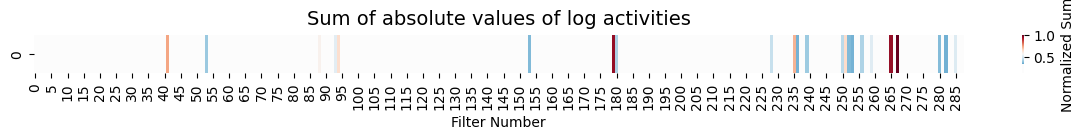

In [ ]:
sum_A = A.abs().sum(axis=1)
sum_A_normalized = sum_A / sum_A.max()
mb.pl.filter_contrib_heatmap(sum_A_normalized, title='Sum of absolute values of log activities', score="Normalized Sum")

(array([  9,  18,  20,  41,  52,  53,  57,  81,  88,  93,  94, 105, 106,
       126, 136, 137, 145, 147, 151, 153, 156, 158, 165, 175, 179, 180,
       181, 182, 196, 200, 201, 211, 219, 228, 230, 232, 233, 234, 235,
       236, 237, 239, 240, 242, 244, 245, 246, 248, 249, 250, 251, 252,
       253, 255, 256, 259, 262, 263, 264, 265, 267, 271, 272, 273, 274,
       276, 279, 280, 282, 284, 285, 286]),)
[145, 147, 181, 182, 246, 286]
tensor(0.2500)


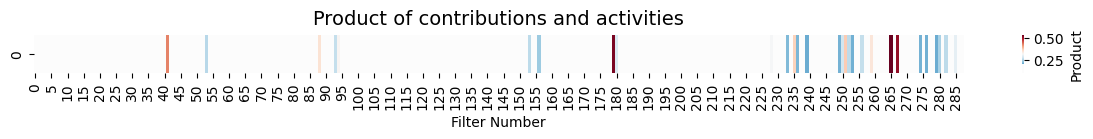

In [ ]:
contrib_np = contributions_normalized.detach().numpy()
sum_A_np = sum_A_normalized.detach().numpy()
rel_idcC = np.where(contrib_np >= np.percentile(contrib_np, 75))
rel_idcA = np.where(sum_A_np >= np.percentile(sum_A_np, 75))
print(rel_idcA)
print([x for x in rel_idcC[0] if x in rel_idcA[0]])

contrib_activites_prod = contributions_normalized * sum_A_normalized
print(sum(contrib_activites_prod >= np.sort(contrib_activites_prod.detach().numpy())[3*len(contrib_activites_prod) // 4])/len(contrib_activites_prod))
mb.pl.filter_contrib_heatmap(contrib_activites_prod, title="Product of contributions and activities", score="Product")

Percentage of non-zero entries of the filter matrix A: 100.0 %


<Figure size 1000x500 with 0 Axes>

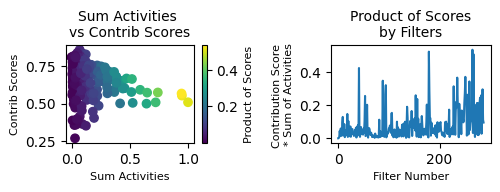

In [ ]:
from matplotlib.pyplot import rcParams
rcParams['figure.dpi'] = 100
plt.figure(figsize=(10, 5))


print(f"Percentage of non-zero entries of the filter matrix A: {100 * torch.sum(A != 0).item() / A.numel()} %")

mb.pl.filter_contrib_simple(contributions_normalized, A, 'filter_contrib_plot.pdf')

In [ ]:
import plotly.graph_objs as go
import numpy as np

# Assuming filter_contrib_normed and A are already defined
filter_contrib_normed = contributions_normalized
contrib_arr = filter_contrib_normed.unsqueeze(dim=0).detach().numpy()
sum_A = A.abs().sum(axis=1).detach().numpy()
sum_A_normalized = sum_A / sum_A.max()
contrib = contrib_arr[0]

# Compute the product of sum_A_normalized and contrib
product = sum_A_normalized * contrib

print(sum_A.shape, contrib.shape)

# Create the 3D scatter plot
trace = go.Scatter3d(
    x=sum_A_normalized,
    y=contrib,
    z=product,
    mode='markers',
    marker=dict(
        size=5,
        color=product,  
        colorscale='Viridis',  
        opacity=0.8
    )
)

data = [trace]

layout = go.Layout(
    margin=dict(l=0, r=0, b=0, t=0),
    scene=dict(
        xaxis_title='Sum Activities (Normalized)',
        yaxis_title='Contrib Scores',
        zaxis_title='Product (Sum Activities * Contrib Scores)'
    )
)

fig = go.Figure(data=data, layout=layout)

fig.show()


(288,) (288,)


In [ ]:
# normalize the data, and look at summary stats
sum_A = A.abs().sum(axis=1).detach().numpy()
sum_A_norm = sum_A / np.max(sum_A)
sum_A_df = pd.DataFrame(sum_A_norm, columns=['sum_A'])
sum_A_df.describe()
print(np.sort(sum_A_norm)[:-10:-1])

[1.         0.94741637 0.94439757 0.7404927  0.7216909  0.6486052
 0.6430217  0.5884509  0.5243953 ]


In [ ]:
contrib_arr = contributions_normalized.unsqueeze(dim=0).detach().numpy()
sum_A = A.abs().sum(axis=1).detach().numpy()
contrib = contrib_arr[0]

contrib_times_activities = contrib * sum_A
contrib_times_activities_norm = contrib_times_activities / np.max(contrib_times_activities)
contrib_times_activities_df = pd.DataFrame(contrib_times_activities, columns=['contribution_times_activities'])
contrib_times_activities_df.describe()

,contribution_times_activities
count,288.000000
mean,6.565629
std,7.652411
min,0.001339
25%,1.655675
50%,3.679736
75%,8.155237
max,44.861660


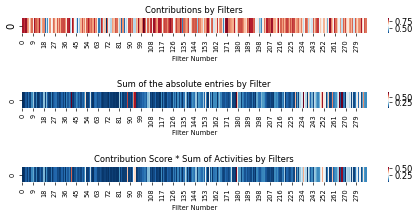

In [32]:
from matplotlib.pyplot import rcParams
rcParams['figure.dpi'] = 60

mb.pl.contrib_heatmaps(A, C, D, use_hadamard=False, save_pdf=True)

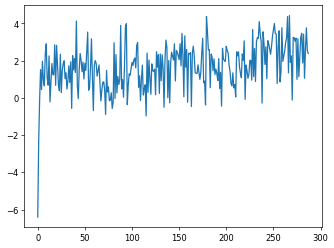

In [ ]:
plt.plot(np.log(sum_A))
plt.show()